In [26]:
import os 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import unittest



# missing: Test assertions, whole current clamp part, GUI (streamlit local host?, flask)
# maybe replace pandas operations by numpy for speed
# implement statistical tests
# maybe use heka reade directly to get the traces?

class patch_structure():
    """ Integrated and analysis patch data derived from HEKA as ASCII files
    First started for voltage clamp analysis"""
    
    def __init__(self, path, metadatas, delimiter):
        """ initialize the datastructure
        using the path and the data_index list
        path -> path of data
        data -> list of data
        metadata -> path to metadata table in csv, txt, ascii
        datalist -> 
        normalized_data ->
        traces -> IV traces
        group_dictionary -> integrated MetaData
        voltage_traces ->  raw voltage_traces
        resting_table -> results for resting membrane potential
        """
        # Test for the Path where the data is located if str
        if  all(isinstance(i, str) for i in [path, metadatas]):
            self.path = path
            self.data = [i for i in os.listdir(path) if ".asc" in i]
            self.metadata = pd.read_csv(metadatas, delimiter = delimiter)
        else: 
            raise TypeError("Provide an existing path as str") 
            
        self.datalist = []
        self.normalized_data = []
        self.traces = []
        self.group_dictionary = None
        self.voltage_traces = None
        self.resting_table = None
        self.files_overview = None # to receive an overview of all the columns 
        
    
    def initialize(self,index, skiprows):
        """ initalizes the datastructure """
        if isinstance(skiprows, int):
            for i in self.data:
                if ".asc" in i:
                    df = pd.read_csv(self.path + "/" + str(i), skiprows = skiprows)
                    columns = [i.replace('"', "") for i in df.columns] # if necessary replaces string literals in columns
                    columns = [i.replace(" ","") for i in columns] # White space removals 
                    columns = [name[0:-3] for name in columns] # Removal of the Unit
                    df.columns = columns # maybe check for column equity for all dataframes??
                    df = df.set_index(index) # Sets the selected index from the df columns
                    self.datalist.append(df)
                else:
                    pass
        else:
            raise TypeError("Provide an integer to skip the number of rows that are unnessecary for the dataframe") 
            
        
    def normalize(self, rows, normalizer):
        """decide which row should be normalized by which other rows depending on the datastructure
        rows should be added as list"""
        for i in self.datalist:
            i[rows] = i[rows].div(i[normalizer], axis = 0)
            self.normalized_data.append(i)
            
    def IV_trace(self):
        """ get the data for the selected currents and save them in a list of current data (maybe also dictionary)
         """
        #maybe replace by one dictionary instead of multiple ones to select the columns one would like to use?
        peak_traces = {}
        sustained_traces ={}
        maxed_traces = {}
        end_max = {}
        cslow = {}
        files = [i[:-4] for i in self.data]
        self.files_overview = files.copy()
        for i,t in zip(self.normalized_data, files):
            #here the columns of choice should be implemented
            sus = {t: i["Isus"]} 
            peak = {t: i["Ipeak"]}
            maximum = {t:i["Imax"]}
            max_end = {t:i["Imax"]}
            cslowed = {t: i["Cslow"]}
            
            #update the dictionary with this columns
            peak_traces.update(peak)
            sustained_traces.update(sus)
            maxed_traces.update(maximum)
            end_max.update(max_end)
            cslow.update(cslowed)

        #get the dataframes for each of the corresponding datasets
        peaks = pd.DataFrame(peak_traces)
        susts = pd.DataFrame(sustained_traces)
        maxs = pd.DataFrame(maxed_traces)
        ending = pd.DataFrame(end_max)
        cslow_df = pd.DataFrame(cslow)
        
        self.voltage_traces = [peaks,susts,maxs,ending, cslow_df]
        
    def integrate_metadata(self, data_row, group_row, sample_size = None):
        """drawing mean traces based on metadata
        data_row -> the columns in metadatafile with the data names
        group_row ->the column in metadatafile with the corresponding sample group
        output --> dictionary with raw analysis files grouped according to their class
        sample_sizes = Number of samples per condition shown"""
        
        #get the column name of the three groups
        groups = self.metadata["group"].unique()
        
        self.group_dictionary = {}
        
        for i in groups:
            treatment_group = self.metadata[self.metadata[group_row] == i][data_row].tolist()
            meta = {str(i):treatment_group}
            self.group_dictionary.update(meta) # metadata integration stored in the object
            
            if sample_size:
                print("group: " + i + " number of samples: " + str(len(treatment_group)))
    
    def draw_traces(self,current, title):
        
        """draw the traces for the data"""
        current_data = self.voltage_traces[current]
        current_dataframe = pd.DataFrame()
        fig,ax = plt.subplots()
        print(current_data)

        for key,value in self.group_dictionary.items():
            currents = current_data[value].mean(axis = 1)
            sem_current = current_data[value].sem(axis = 1)
            current_dataframe[key] = currents
            current_dataframe[key +"_sem"] = sem_current
            sns.lineplot(x = current_dataframe.index, y = key, data = current_dataframe, color = "blue")
            plt.errorbar(current_dataframe.index, current_dataframe[key], yerr=current_dataframe[key + "_sem"], fmt='-o')
            plt.ylabel("normalized current")
            plt.xlabel("voltage-steps") 
            plt.title(title)
        
    def draw_cslow(self,current):
        """ draw an cslow overview to get the capicitance for each recording and compare cell sizes
        """
        current_data = self.voltage_traces[current]
        current_dataframe = pd.DataFrame()
        for key,value in self.group_dictionary.items():
            currents = current_data[value].mean(axis = 1)
            sem_current = current_data[value].sem(axis = 1)
            current_dataframe[key] = currents
            current_dataframe[key +"_sem"] = sem_current
        
        mean_dataframe = pd.DataFrame(current_dataframe[["ctrl","ngf","gdnf"]].mean(axis = 0))
        sem_dataframe = pd.DataFrame(current_dataframe[["ctrl_sem","ngf_sem","gdnf_sem"]].mean(axis = 0))
        sem_dataframe.columns = ["sem"]
        sem = sem_dataframe["sem"].tolist()
        mean_dataframe["sem"] = sem
        mean_dataframe.columns = ["mean", "sem"]
        print(mean_dataframe)
        mean_dataframe.plot(kind = "bar", y = "mean", yerr = "sem")
        
    def resting_membrane(self):
        data = {"data":[],"mean_1":[],"mean_2":[],"mean_3":[]}
        for i,t in zip(self.data, self.datalist):
            data["data"].append(i)
            data["mean_1"].append(t["Mean-1"].tolist()[0])
            data["mean_2"].append(t["Mean-2"].tolist()[0])
            data["mean_3"].append(t["Mean-3"].tolist()[0])
        self.resting_table = pd.DataFrame(data)
        self.resting_table["data"] = [i[:-4] for i in self.resting_table["data"]]
        key_list = []
        for i in self.resting_table["data"]:
            for key, value in self.group_dictionary.items():
                 if i in value:
                    key_list.append(key)
        self.resting_table["group"] = key_list
        self.resting_table = self.resting_table.drop("data", axis = 1)
    
    def draw_resting_figure(self):
        resting_potential = pd.melt(self.resting_table, "group", var_name = "mean_1")
        fig,ax = plt.subplots()
        sns.despine()
        sns.boxplot(x = "mean_1", hue = "group", y = "value", data = resting_potential, palette = "tab20")
        plt.ylabel("resting-membrane potential in V")
        plt.xlabel("")


class current(patch_structure):
    
    #should add all the object related variables to the init
    #def __init__(self):
        #super().__init__()
    
    def traces_input(self, output = None):

        """  Draw the raw current from the selected files
        output -> True (default = None) should draw currents directly """
        traces = {}
        for i,t in tqdm(zip(self.datalist, self.data)):
            d = {t:i["Vmon"]}
            traces.update(d)
            if output:
                fig, ax = plt.subplots(figsize = (15,5))
                sns.lineplot(x = i.index, y = i["Vmon"], linewidth = 1, color = "green")
                plt.title("Name of Experiment: " + str(t))
                plt.xlabel("Time")
                plt.ylabel("Voltage in V") 
                plt.show()  
        self.trace_df = pd.DataFrame(traces)
    
    def cluster_traces(self, pca = None, correlation = True):
        """ cluster the Raw currents based on correltion and/or principle component anaylsis for qualty assessment
        correlation -> (default = True) draws Clustermap of correlated data
        pca = (default = None) draws the scatterplot with explained variance for the first 2 principle components"""

        if correlation:
            correlation = self.trace_df.corr()
            sns.clustermap(correlation)
        
        pca = PCA(n_components = 2) #initialize the model with default parameters
        pcs = pca.fit_transform(self.trace_df.T)
        Title = pca.explained_variance_ratio_ #receives the explained variance for the first two principle compenents
        pca_df = pd.DataFrame(columns = ["PC1","PC2"],data = pcs)

        #draws the plot
        fig, ax = plt.subplots()
        sns.scatterplot(x = "PC1", y= "PC2", data = pca_df)
        plt.xlabel("PC1" + " (" + str(format(Title[0], '.2f')) + ")")
        plt.ylabel("PC2" + " (" + str(format(Title[1], '.2f')) + ")")
        plt.show()
        

           201221_06   201221_12   201221_13   201221_07   201228_23  \
Voltage2                                                               
-0.060     -0.022321   -0.234015   -0.433702   -0.018340    0.110442   
-0.055     -0.034524   -0.147059    0.002845   -0.088417   -0.067671   
-0.050     -0.176190   -0.104859   -0.033702   -0.114286   -0.359438   
-0.045     -0.779762   -0.719949   -0.386740   -0.376448   -1.038153   
-0.040     -3.095238   -3.925831   -2.646409   -1.969112   -3.112450   
-0.035   -372.023810 -179.028133 -104.696133 -312.741313 -275.100402   
-0.030   -366.071429 -164.961637 -103.314917 -332.432432 -259.036145   
-0.025   -413.690476 -162.404092  -95.303867 -343.243243 -257.028112   
-0.020   -431.547619 -166.240409  -93.370166 -349.806950 -269.076305   
-0.015   -428.571429 -156.010230  -93.646409 -341.698842 -275.100402   
-0.010   -416.666667 -152.173913  -93.093923 -325.096525 -271.084337   
-0.005   -398.809524 -144.501279  -93.093923 -305.791506 -263.05

['201221_06',
 '201221_12',
 '201221_13',
 '201221_07',
 '201228_23',
 '201228_09',
 '201221_11',
 '201228_21',
 '201221_05',
 '201228_20',
 '201221_04',
 '201221_10',
 '201221_14',
 '201228_18',
 '201228_19',
 '201221_01',
 '201228_25',
 '201221_15',
 '201221_03',
 '201221_17',
 '201221_16',
 '201228_26',
 '201221_02',
 '201228_03',
 '201228_17',
 '201228_16',
 '201221_18',
 '201228_14',
 '201228_01',
 '201228_15',
 '201221_19',
 '201228_11',
 '201221_21',
 '201221_08',
 '201228_10',
 '201228_06',
 '201221_22',
 '201228_12',
 '201228_13',
 '201228_07']

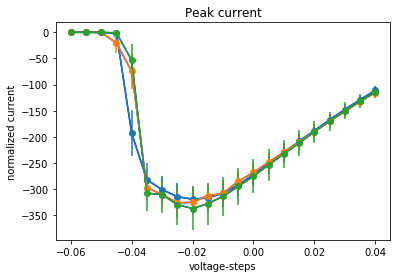

In [27]:
# here an overview to draw the peak current

obj = patch_structure("/Users/maximilianzeidler/Dropbox/Patch_clamp/Etool/Data/IV", "/Users/maximilianzeidler/Dropbox/Patch_clamp/Etool/Data/Metadata/patch_clamp_metadata.csv", "\t"
        )
obj.initialize("Voltage2", 1)
obj.normalize(["Ipp_bas","Ipp_beg","Ipp_end","Ipeak","Isus","Imax","Max_end"], "Cslow")
obj.IV_trace()
obj.integrate_metadata("data","group")
obj.draw_traces(0,"Peak current")
obj.files_overview

In [12]:
# testing the pathes
obj1 = patch_structure(1,2,"/t")

TypeError: Provide an existing path as str